## Setup Project
Import used packages


In [1]:
# import required libraries
import os
import numpy as np
import scipy as sp
import matplotlib as mpl
from astropy.table import Table
import glob
import warnings
from sklearn.mixture import GaussianMixture



Setup global plot settings

In [2]:

# configure notebook for plotting
%pylab inline --no-import-all 
mpl.style.use('seaborn-colorblind') # colourblind-friendly colour scheme
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color'] # allows access to colours
# subsequent lines default plot settings
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(8.0,6.0)    
matplotlib.rcParams['font.size']=16                
matplotlib.rcParams['savefig.dpi']= 300              
warnings.filterwarnings('ignore')


Populating the interactive namespace from numpy and matplotlib


## Data entry and categorisation
Enter data file location and initiate variables

In [3]:

# import data from Data directory
allPointsFiles = glob.glob('../Data/*/*/points.txt')
allFuzzyFiles = glob.glob('../Data/*/*/fuzzy.txt')
allVaryingPointFiles = glob.glob('../Data/*/*/P*.csv')
allXrayFiles = glob.glob('../Data/XrayFlash.txt')
farPoints = []
closePoints = []
variablePoints = []
xRayPoints = []
totalPoints = 0


### Categorise and process Points
Iterate through points files and categorize points into close and far points, where close points can be measured by parallax accurately.\
Convert to useful data types in process.

In [4]:
for j, pointsFile in enumerate(allPointsFiles):
    try:
        this = Table.read(pointsFile,format='ascii')
        totalPoints= totalPoints+len(this)
        thispar = this['par']
        thism0, thism1, thism2 = (np.log10(this['flux1']), 
                                  np.log10(this['flux2']), 
                                  np.log10(this['flux3']))
        thiscolour = thism2-thism0
        dist = 1/thispar
        abs_mag = thism1 + 2*np.log10(dist)
        
        # transform coords onto "sky net" based on file path and store in numpy array          
        if pointsFile.rfind('Up')!=-1:
            points = np.array([this['name'], this['y'], -this['x']+90, thispar, thiscolour, abs_mag, this['rv']]).T.tolist()
        elif pointsFile.rfind('Front')!=-1:
            points = np.array([this['name'], this['y']-90, -this['x']+90, thispar, thiscolour, abs_mag, this['rv']]).T.tolist()
        elif pointsFile.rfind('Right')!=-1:
            points = np.array([this['name'], this['x'], this['y'], thispar, thiscolour, abs_mag, this['rv']]).T.tolist()
        elif pointsFile.rfind('Back')!=-1:
            points = np.array([this['name'], this['x']+90, this['y'], thispar, thiscolour, abs_mag, this['rv']]).T.tolist()
        elif pointsFile.rfind('Left')!=-1:
            points = np.array([this['name'], this['y']-90, -this['x']+180, thispar, thiscolour, abs_mag, this['rv']]).T.tolist()
        elif pointsFile.rfind('Down')!=-1:
            points = np.array([this['name'], this['y'], -this['x']-90, thispar, thiscolour, abs_mag, this['rv']]).T.tolist()
            
        # sort into close and far
        for point in points:
            if float(point[3]) > 0.01:
                closePoints.append(point)
            else:
                farPoints.append(point)                
    except:
        pass
closePointsNumpy=np.array(closePoints)
farPointsNumpy=np.array(farPoints)

### Categorise Fuzzies
A similar process as used on the points data

### Categorise Xray flashes


In [5]:
for j, XrayFiles in enumerate(allXrayFiles):
    try:
        this = Table.read(XrayFiles,format='ascii')
        for line in this:
            # transform coords onto "sky net" based on file path and store in numpy array          
            if line['Camera']==('Up'):
                Xrays = np.array([line['y'], -line['x']+90, line['mag']]).T.tolist()
            elif line['Camera']==('Front'):
                Xrays = np.array([ line['y']-90, -line['x']+90, line['mag']]).T.tolist()
            elif line['Camera']==('Right'):
                Xrays = np.array([ line['x'], line['y'], line['mag']]).T.tolist()
            elif line['Camera']==('Back'):
                Xrays = np.array([line['x']+90, line['y'], line['mag']]).T.tolist()
            elif line['Camera']==('Left'):
                Xrays = np.array([ line['y']-90, -line['x']+180, line['mag']]).T.tolist()
            elif line['Camera']==('Down'):
                Xrays = np.array([ line['y'], -line['x']-90, line['mag']]).T.tolist()

            xRayPoints.append(Xrays)
    except:
        pass
xRayPointsNumpy=np.array(xRayPoints)

## Initial Plots
A star map to check all are present, a benchmark HR diagram and a cluster map.

### HR benchmark

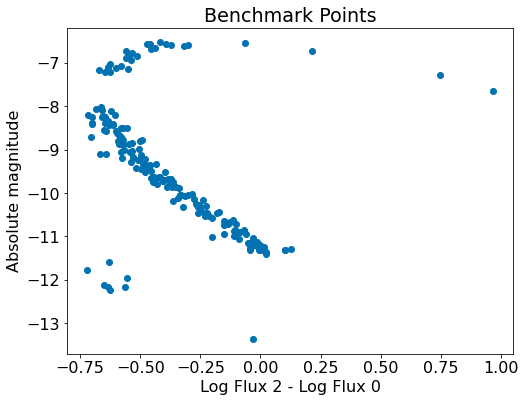

In [6]:

# figure for HR diagram benchmark
figHRBenchMark = plt.figure()
plt.ylabel('Absolute magnitude')
plt.xlabel('Log Flux 2 - Log Flux 0')
plt.title('Benchmark Points')
plt.scatter((closePointsNumpy.T)[4].astype(np.float),(closePointsNumpy.T)[5].astype(np.float))


### Sky Net

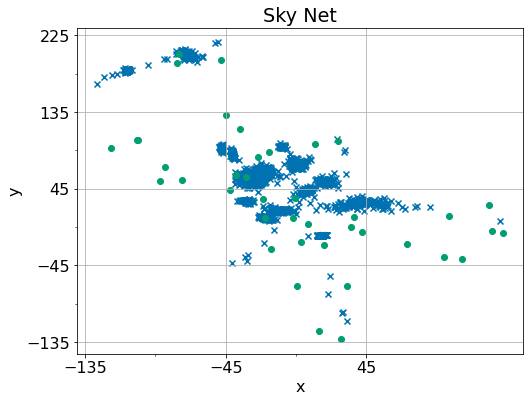

In [7]:
# figure for HR diagram benchmark
skyNet= plt.figure()
ax = skyNet.add_subplot(1, 1, 1)
plt.ylabel('y')
plt.xlabel('x')
plt.title('Sky Net')
plt.scatter((farPointsNumpy.T)[1].astype(np.float),(farPointsNumpy.T)[2].astype(np.float), marker = 'x')
plt.scatter((xRayPointsNumpy.T)[0].astype(np.float),(xRayPointsNumpy.T)[1].astype(np.float), marker = 'o')
yticksMajor = [-135,-45,45,135,225]
yticksMinor = [-90,0,90,180]
xticksMajor = [-135,-45,45]
xticksMinor = [-90,0]

ax.set_xticks(xticksMajor)
ax.set_yticks(yticksMajor)
ax.set_xticks(xticksMinor, minor=True)
ax.set_yticks(yticksMinor, minor=True)
plt.grid()

## Identify all point clusters

In [8]:
ClustersModel = GaussianMixture(covariance_type="full").fit_predict(farPointsNumpy[:,[1,2]])



In [9]:

# figure for HR diagram benchmark
#figHRBenchMark = plt.figure()
#plt.ylabel('Absolute magnitude')
#plt.xlabel('Log Flux 2 - Log Flux 0')
#plt.title('far Points')
#plt.scatter((farPointsNumpy.T)[4].astype(np.float),(farPointsNumpy.T)[5].astype(np.float), marker='x')